# Exercise 4. - Data Cleansing

## Handling Missing Values in Python

![Missing values](missing.png)

Real world data is messy and often contains a lot of missing values. 

There could be multiple reasons for the missing values but primarily the reason for missingness can be attributed to:

| Reason for missing Data | 
| :-----------: | 
| Data doesn't exist |
| Data not collected due to human error. | 
| Data deleted accidently |

## A guide to handling missing values 

Please read this tutorial on handling missing values first, before working on dirty data this week: [TUTORIAL](a_guide_to_na.ipynb).

# Dirty data

In [183]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings
import ssl
# Suppress warnings
warnings.filterwarnings('ignore')
# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context
import requests
from io import StringIO

Load the dataset from the provided URL using pandas.

In [184]:
url = "https://raw.github.com/edwindj/datacleaning/master/data/dirty_iris.csv"
response = requests.get(url, verify=False)
data = StringIO(response.text)
dirty_iris = pd.read_csv(data, sep=",")
print(dirty_iris.head())  

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
0           6.4          3.2           4.5          1.5  versicolor
1           6.3          3.3           6.0          2.5   virginica
2           6.2          NaN           5.4          2.3   virginica
3           5.0          3.4           1.6          0.4      setosa
4           5.7          2.6           3.5          1.0  versicolor


## Introduce Missing Values

Randomly introduce missing values into the dataset to mimic the Python code behavior.

In [185]:
# Load additional data
carseats = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/Carseats.csv")

# Set random seed for reproducibility
np.random.seed(123)

# Introduce missing values in 'Income' column
income_missing_indices = np.random.choice(carseats.index, size=20, replace=False)
carseats.loc[income_missing_indices, 'Income'] = np.nan

# Set another random seed for reproducibility
np.random.seed(456)

# Introduce missing values in 'Urban' column
urban_missing_indices = np.random.choice(carseats.index, size=10, replace=False)
carseats.loc[urban_missing_indices, 'Urban'] = np.nan

# Introduction

Analysis of data is a process of inspecting, cleaning, transforming, and modeling data with the goal of highlighting useful information, suggesting conclusions and supporting decision making.

![Descriptive Statistics](images/ds.png)

Many times in the beginning we spend hours on handling problems with missing values, logical inconsistencies or outliers in our datasets. In this tutorial we will go through the most popular techniques in data cleansing.


We will be working with the messy dataset `iris`. Originally published at UCI Machine Learning Repository: Iris Data Set, this small dataset from 1936 is often used for testing out machine learning algorithms and visualizations. Each row of the table represents an iris flower, including its species and dimensions of its botanical parts, sepal and petal, in centimeters.

Take a look at this dataset here:

In [186]:
dirty_iris

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,6.4,3.2,4.5,1.5,versicolor
1,6.3,3.3,6.0,2.5,virginica
2,6.2,NaN,5.4,2.3,virginica
3,5.0,3.4,1.6,0.4,setosa
4,5.7,2.6,3.5,1.0,versicolor
...,...,...,...,...,...
145,6.7,3.1,5.6,2.4,virginica
146,5.6,3.0,4.5,1.5,versicolor
147,5.2,3.5,1.5,0.2,setosa
148,6.4,3.1,NaN,1.8,virginica


## Detecting NA

A missing value, represented by NaN in Python, is a placeholder for a datum of which the type is known but its value isn't. Therefore, it is impossible to perform statistical analysis on data where one or more values in the data are missing. One may choose to either omit elements from a dataset that contain missing values or to impute a value, but missingness is something to be dealt with prior to any analysis.


![Descriptive Statistics](images/ds.png)

Can you see that many values in our dataset have status NaN = Not Available? Count (or plot), how many (%) of all 150 rows is complete.


In [187]:
# Count the number of complete cases (rows without any missing values)
complete_cases = dirty_iris.dropna().shape[0]

# Calculate the percentage of complete cases
percentage_complete = (complete_cases / dirty_iris.shape[0]) * 100

print(f"Number of complete cases: {complete_cases}")
print(f"Percentage of complete cases: {percentage_complete:.2f}%")

Number of complete cases: 96
Percentage of complete cases: 64.00%


Does the data contain other special values? If it does, replace them with NA.

In [188]:
# Define a function to check for special values
def is_special(x):
    if np.issubdtype(x.dtype, np.number):
        return ~np.isfinite(x)
    else:
        return pd.isna(x)

# Apply the function to each column and replace special values with NaN
for col in dirty_iris.columns:
    dirty_iris[col] = dirty_iris[col].apply(lambda x: np.nan if is_special(pd.Series([x]))[0] else x)

# Display summary of the data
print(dirty_iris.describe(include='all'))

        Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
count     140.000000   133.000000    131.000000   137.000000         150
unique           NaN          NaN           NaN          NaN           3
top              NaN          NaN           NaN          NaN  versicolor
freq             NaN          NaN           NaN          NaN          50
mean        6.559286     3.390977      4.449962     1.207299         NaN
std         6.800940     3.315310      5.769299     0.764722         NaN
min         0.000000    -3.000000      0.000000     0.100000         NaN
25%         5.100000     2.800000      1.600000     0.300000         NaN
50%         5.750000     3.000000      4.500000     1.300000         NaN
75%         6.400000     3.300000      5.100000     1.800000         NaN
max        73.000000    30.000000     63.000000     2.500000         NaN


## Checking consistency

Consistent data are technically correct data that are fit for statistical analysis. They are data in which missing values, special values, (obvious) errors and outliers are either removed, corrected or imputed. The data are consistent with constraints based on real-world knowledge about the subject that the data describe.

![Iris](images/iris.png)

We have the following background knowledge:

-   Species should be one of the following values: setosa, versicolor or virginica.

-   All measured numerical properties of an iris should be positive.

-   The petal length of an iris is at least 2 times its petal width.

-   The sepal length of an iris cannot exceed 30 cm.

-   The sepals of an iris are longer than its petals.

Define these rules in a separate object 'RULES' and read them into Python. Print the resulting constraint object.

In [189]:
# Define the rules as functions
def check_rules(df):
    rules = {
        "Sepal.Length <= 30": df["Sepal.Length"] <= 30,
        "Species in ['setosa', 'versicolor', 'virginica']": df["Species"].isin(['setosa', 'versicolor', 'virginica']),
        "Sepal.Length > 0": df["Sepal.Length"] > 0,
        "Sepal.Width > 0": df["Sepal.Width"] > 0,
        "Petal.Length > 0": df["Petal.Length"] > 0,
        "Petal.Width > 0": df["Petal.Width"] > 0,
        "Petal.Length >= 2 * Petal.Width": df["Petal.Length"] >= 2 * df["Petal.Width"],
        "Sepal.Length > Petal.Length": df["Sepal.Length"] > df["Petal.Length"]
    }
    return rules

# Apply the rules to the dataframe
rules = check_rules(dirty_iris)

# Print the rules
for rule, result in rules.items():
    print(f"{rule}: {result.all()}")

Sepal.Length <= 30: False
Species in ['setosa', 'versicolor', 'virginica']: True
Sepal.Length > 0: False
Sepal.Width > 0: False
Petal.Length > 0: False
Petal.Width > 0: False
Petal.Length >= 2 * Petal.Width: False
Sepal.Length > Petal.Length: False


Now we are ready to determine how often each rule is broken (violations). Also we can summarize and plot the result.

In [190]:
# Check for rule violations
violations = {rule: ~result for rule, result in rules.items()}

# Summarize the violations
summary = {rule: result.sum() for rule, result in violations.items()}

# Print the summary of violations
print("Summary of Violations:")
for rule, count in summary.items():
    print(f"{rule}: {count} violations")

Summary of Violations:
Sepal.Length <= 30: 12 violations
Species in ['setosa', 'versicolor', 'virginica']: 0 violations
Sepal.Length > 0: 11 violations
Sepal.Width > 0: 19 violations
Petal.Length > 0: 20 violations
Petal.Width > 0: 13 violations
Petal.Length >= 2 * Petal.Width: 34 violations
Sepal.Length > Petal.Length: 30 violations


What percentage of the data has no errors?

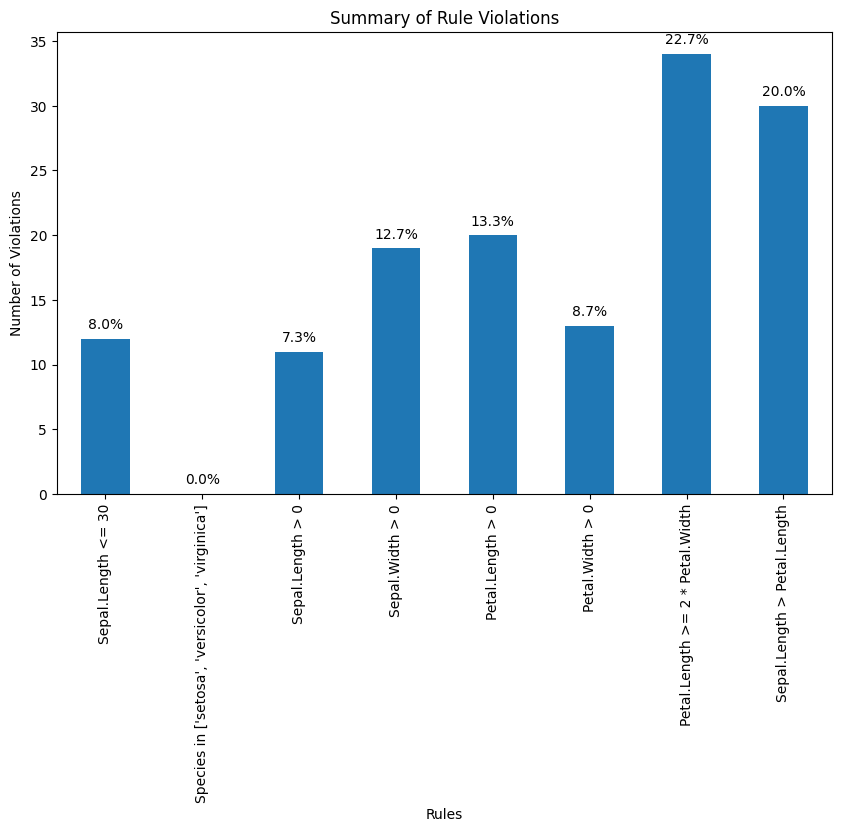

In [191]:
import matplotlib.pyplot as plt
# Plot the violations
violation_counts = pd.Series(summary)
ax = violation_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Summary of Rule Violations')
plt.xlabel('Rules')
plt.ylabel('Number of Violations')
plt.savefig('./Exercise_4_images/1.png')
# Add percentage labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height() / len(dirty_iris) * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points')

plt.show()

Find out which observations have too long sepals using the result of violations.

In [192]:
# Check for rule violations
violations = {rule: ~result for rule, result in rules.items()}
# Combine violations into a DataFrame
violated_df = pd.DataFrame(violations)
violated_rows = dirty_iris[violated_df["Sepal.Length <= 30"]]
print(violated_rows)

     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
14            NaN          3.9          1.70          0.4      setosa
18            NaN          4.0           NaN          0.2      setosa
24            NaN          3.0          5.90          2.1   virginica
27           73.0         29.0         63.00          NaN   virginica
29            NaN          2.8          0.82          1.3  versicolor
57            NaN          2.9          4.50          1.5  versicolor
67            NaN          3.2          5.70          2.3   virginica
113           NaN          3.3          5.70          2.1   virginica
118           NaN          3.0          5.50          2.1   virginica
119           NaN          2.8          4.70          1.2  versicolor
124          49.0         30.0         14.00          2.0      setosa
137           NaN          3.0          4.90          1.8   virginica


Find outliers in sepal length using boxplot approach. Retrieve the corresponding observations and look at the other values. Any ideas what might have happened? Set the outliers to NA (or a value that you find more appropiate)

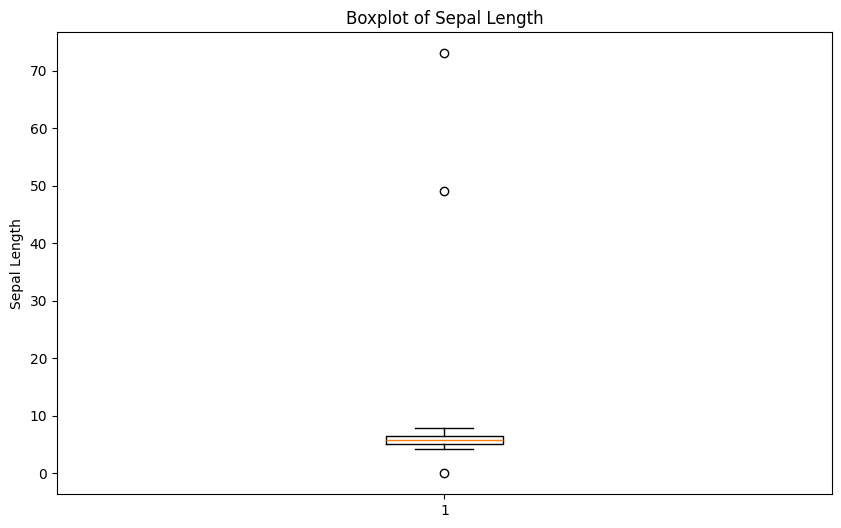

In [193]:
# Boxplot for Sepal.Length
plt.figure(figsize=(10, 6))
plt.boxplot(dirty_iris['Sepal.Length'].dropna())
plt.title('Boxplot of Sepal Length')
plt.ylabel('Sepal Length')
plt.savefig('./Exercise_4_images/2.png')
plt.show()

In [194]:
# Find outliers in Sepal.Length
outliers = dirty_iris['Sepal.Length'][np.abs(dirty_iris['Sepal.Length'] - dirty_iris['Sepal.Length'].mean()) > (1.5 * dirty_iris['Sepal.Length'].std())]
outliers_idx = dirty_iris.index[dirty_iris['Sepal.Length'].isin(outliers)]

# Print the rows with outliers
print("Outliers:")
print(dirty_iris.loc[outliers_idx])

Outliers:
     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width    Species
27           73.0         29.0          63.0          NaN  virginica
124          49.0         30.0          14.0          2.0     setosa


They all seem to be too big... may they were measured in mm i.o cm?

In [195]:
# Adjust the outliers (assuming they were measured in mm instead of cm)
dirty_iris.loc[outliers_idx, ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']] /= 10

# Summary of the adjusted data
print("Summary of adjusted data:")
print(dirty_iris.describe())

Summary of adjusted data:
       Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
count    140.000000   133.000000    131.000000   137.000000
mean       5.775000     2.991729      3.920954     1.194161
std        0.969842     0.708075      2.455417     0.766463
min        0.000000    -3.000000      0.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.700000     3.000000      4.400000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.200000     23.000000     2.500000



Note that simple boxplot shows an extra outlier!

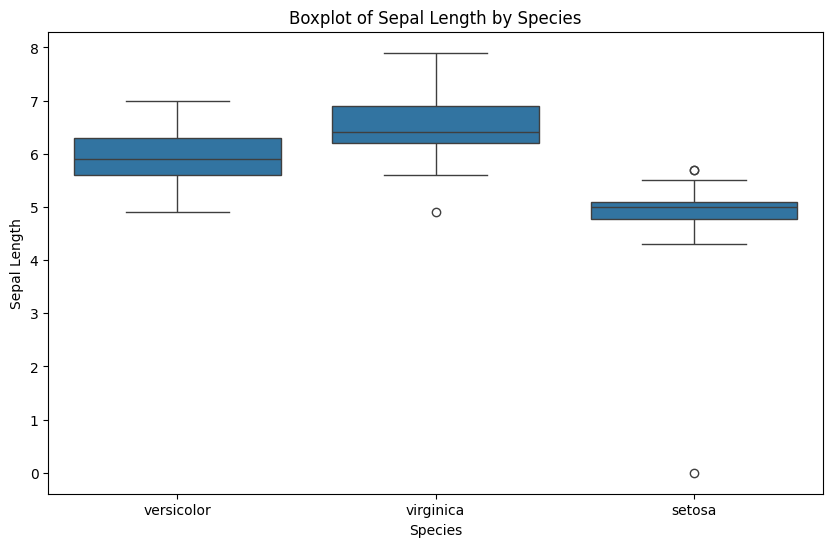

In [196]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Species', y='Sepal.Length', data=dirty_iris)
plt.title('Boxplot of Sepal Length by Species')
plt.xlabel('Species')
plt.ylabel('Sepal Length')
plt.savefig('./Exercise_4_images/3.png')
plt.show()

## Correcting

Replace non positive values from Sepal.Width with NA:

In [197]:
# Define the correction rule
def correct_sepal_width(df):
    df.loc[(~df['Sepal.Width'].isna()) & (df['Sepal.Width'] <= 0), 'Sepal.Width'] = np.nan
    return df

# Apply the correction rule to the dataframe
mydata_corrected = correct_sepal_width(dirty_iris)

# Print the corrected dataframe
print(mydata_corrected)

     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
0             6.4          3.2           4.5          1.5  versicolor
1             6.3          3.3           6.0          2.5   virginica
2             6.2          NaN           5.4          2.3   virginica
3             5.0          3.4           1.6          0.4      setosa
4             5.7          2.6           3.5          1.0  versicolor
..            ...          ...           ...          ...         ...
145           6.7          3.1           5.6          2.4   virginica
146           5.6          3.0           4.5          1.5  versicolor
147           5.2          3.5           1.5          0.2      setosa
148           6.4          3.1           NaN          1.8   virginica
149           5.8          2.6           4.0          NaN  versicolor

[150 rows x 5 columns]


Replace all erroneous values with NA using (the result of) localizeErrors:

In [198]:
# Apply the rules to the dataframe
rules = check_rules(dirty_iris)
violations = {rule: ~result for rule, result in rules.items()}
violated_df = pd.DataFrame(violations)

# Localize errors and set them to NA
for col in violated_df.columns:
    dirty_iris.loc[violated_df[col], col.split()[0]] = np.nan

# NA's pattern detection

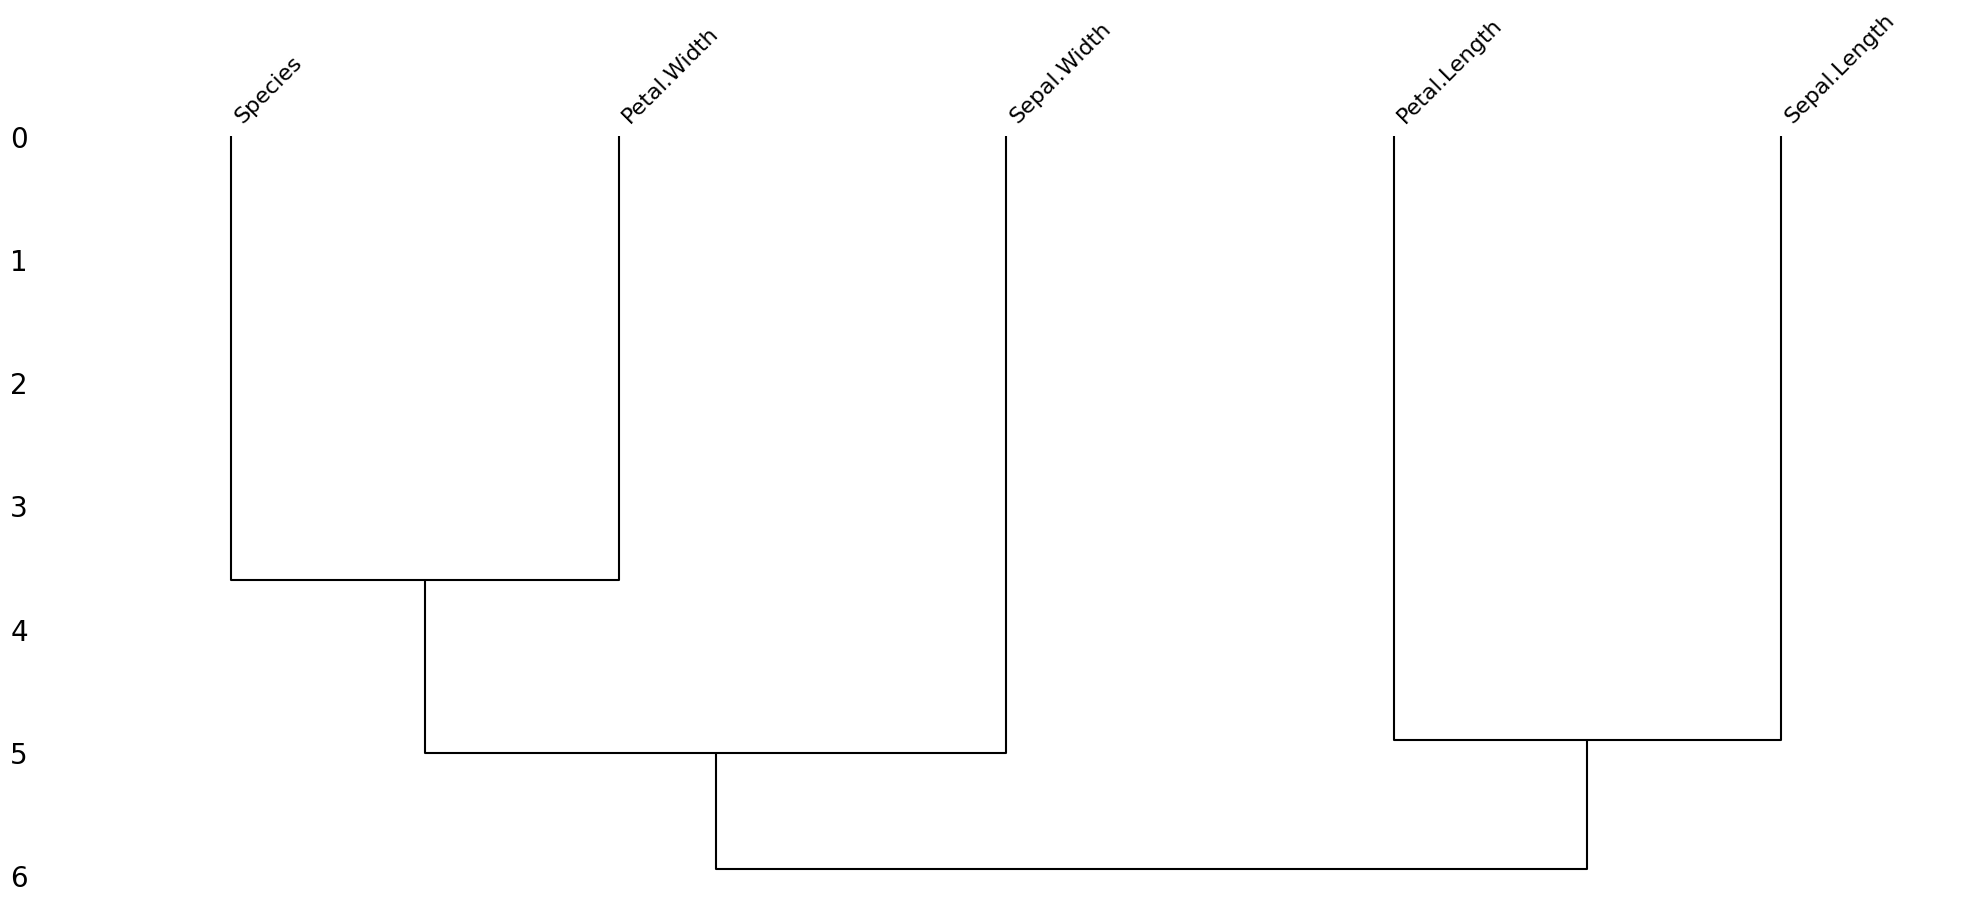

In [199]:
import missingno as msno
msno.dendrogram(dirty_iris);
plt.savefig('./Exercise_4_images/4.png')
# homework describe approaches to handle missing data and imputations methods, find out how to do it using existing libraries, in python
# row-wise or column-wise deletion, generally not recomended, because you lose a lot of data
# To imputate, we may use mean, median, mode - generaly a fixed value, this would be a simple imputation method
# or we can use a more sophisticated method, like KNN, which uses the distance between points to find similar points and fill in the missing values
# we may also use MICE, which is a more advanced method that uses multiple imputations to fill in the missing values
# in the python library sklean.impute, we can find the KNNImputer, SimpleImputer and IterativeImputer classes, which can be used to impute missing values

## Imputing NA's

Imputation is the process of estimating or deriving values for fields where data is missing. There is a vast body of literature on imputation methods and it goes beyond the scope of this tutorial to discuss all of them.

There is no one single best imputation method that works in all cases. The imputation model of choice depends on what auxiliary information is available and whether there are (multivariate) edit restrictions on the data to be imputed. The availability of R software for imputation under edit restrictions is, to our best knowledge, limited. However, a viable strategy for imputing numerical data is to first impute missing values without restrictions, and then minimally adjust the imputed values so that the restrictions are obeyed. Separately, these methods are available in R.

We can mention several approaches to imputation:

1.  For the **quantitative** variables:

-   imputing by **mean**/**median**/**mode**

-   **KNN** -- K-nearest-neighbors approach

-   **RPART** -- random forests multivariate approach

-   **mice** - Multivariate Imputation by Chained Equations approach

2.  For the **qualitative** variables:

-   imputing by **mode**

-   **RPART** -- random forests multivariate approach

-   **mice** - Multivariate Imputation by Chained Equations approach

    ... and many others. Please read the theoretical background if you are interested in those techniques.



***Exercise 1.*** Use ***kNN*** imputation ('sklearn' package) to impute all missing values. The KNNImputer from sklearn requires all data to be numeric. Since our dataset contains categorical data (e.g., the Species column), you need to handle these columns separately. One approach is to use one-hot encoding for categorical variables before applying the imputer.

In [200]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
# Replace infinite values with NaN
dirty_iris.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate numeric and categorical columns
numeric_cols = dirty_iris.select_dtypes(include=[np.number]).columns
categorical_cols = dirty_iris.select_dtypes(exclude=[np.number]).columns
# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_categorical = pd.DataFrame(encoder.fit_transform(dirty_iris[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

# Combine numeric and encoded categorical columns
combined_data = pd.concat([dirty_iris[numeric_cols], encoded_categorical], axis=1)

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Perform kNN imputation
imputed_data = imputer.fit_transform(combined_data)

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=combined_data.columns)

# Decode the one-hot encoded columns back to original categorical columns
decoded_categorical = pd.DataFrame(encoder.inverse_transform(imputed_df[encoded_categorical.columns]), columns=categorical_cols)

# Combine numeric and decoded categorical columns
final_imputed_data = pd.concat([imputed_df[numeric_cols], decoded_categorical], axis=1)

# Print the imputed data
print(final_imputed_data)

     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
0        6.400000     3.200000      4.500000     1.500000  versicolor
1        6.300000     3.300000      6.000000     2.500000   virginica
2        6.200000     3.033333      5.400000     2.300000   virginica
3        5.000000     3.400000      1.600000     0.400000      setosa
4        5.700000     2.600000      3.500000     1.000000  versicolor
..            ...          ...           ...          ...         ...
145      6.700000     3.100000      5.600000     2.400000   virginica
146      5.600000     3.000000      4.500000     1.500000  versicolor
147      5.200000     3.500000      1.500000     0.200000      setosa
148      6.533333     3.100000      5.166667     1.800000   virginica
149      5.800000     2.600000      3.833333     1.066667  versicolor

[150 rows x 5 columns]


## Transformations

Finally, we sometimes encounter the situation where we have problems with skewed distributions or we just want to transform, recode or perform discretization. Let's review some of the most popular transformation methods.

First, standardization (also known as normalization):

-   **Z-score** approach - standardization procedure, using the formula: $z=\frac{x-\mu}{\sigma}$ where $\mu$ = mean and $\sigma$ = standard deviation. Z-scores are also known as standardized scores; they are scores (or data values) that have been given a common *standard*. This standard is a mean of zero and a standard deviation of 1.

-   **minmax** approach - An alternative approach to Z-score normalization (or standardization) is the so-called MinMax scaling (often also simply called "normalization" - a common cause for ambiguities). In this approach, the data is scaled to a fixed range - usually 0 to 1. The cost of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers. If you would like to perform MinMax scaling - simply substract minimum value and divide it by range:$(x-min)/(max-min)$

In order to solve problems with very skewed distributions we can also use several types of simple transformations:

-   log
-   log+1
-   sqrt
-   x\^2
-   x\^3

***Exercise 2.*** Standardize incomes and present the transformed distribution of incomes on boxplot.

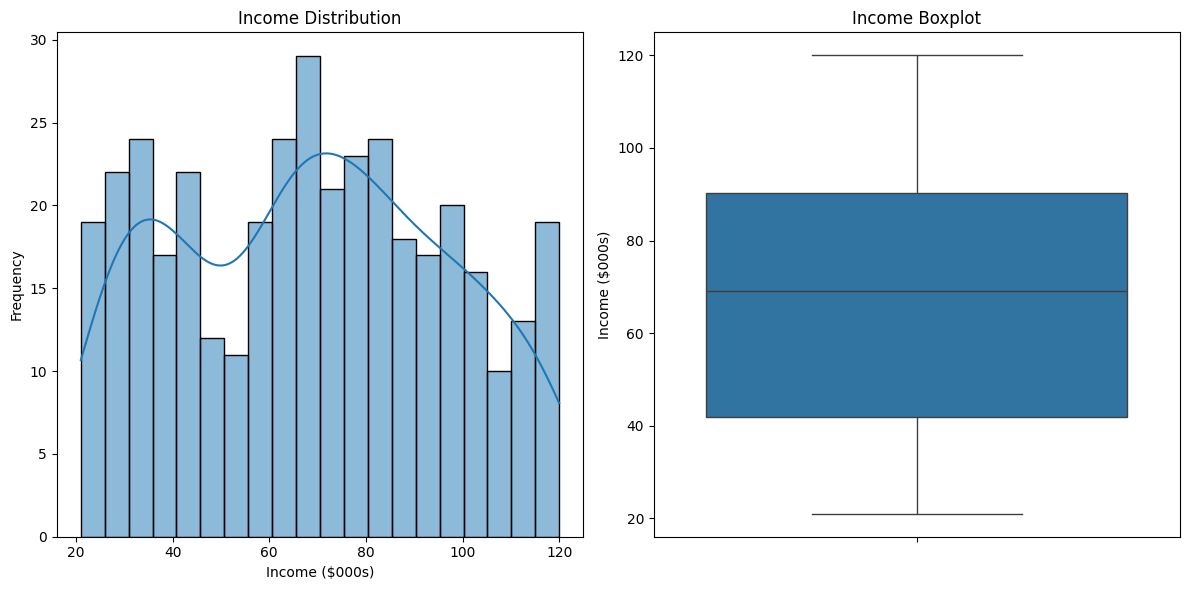

Income statistics:
count    380.000000
mean      68.660526
std       28.007218
min       21.000000
25%       42.000000
50%       69.000000
75%       90.250000
max      120.000000
Name: Income, dtype: float64
Statistics for Z-scaled Income (manual method):
Mean: 0.000000
Standard deviation: 1.000000

Statistics for Z-scaled Income (sklearn method):
Mean: 0.000000
Standard deviation: 1.001252


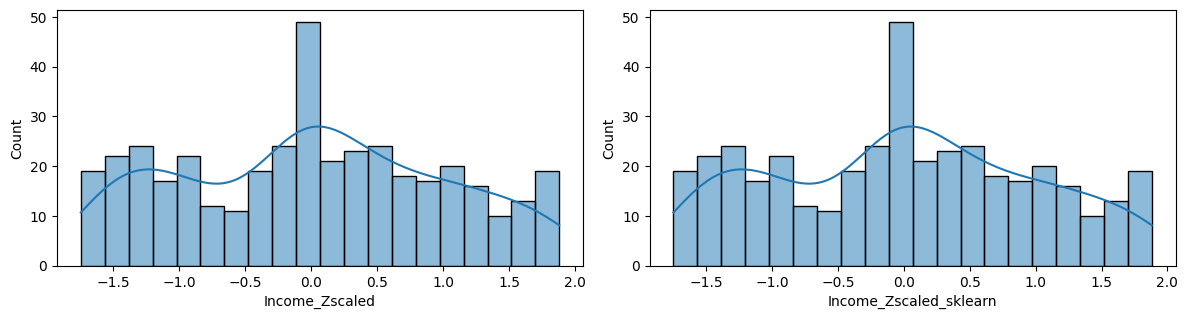

Statistics for MinMax-scaled Income (manual method):
Minimum: 0.000000
Maximum: 1.000000

Statistics for MinMax-scaled Income (sklearn method):
Minimum: 0.000000
Maximum: 1.000000


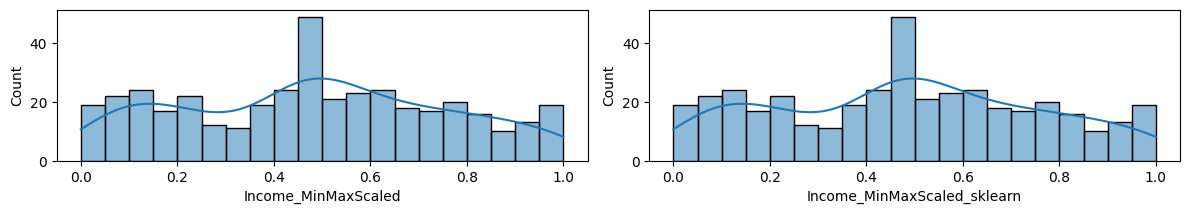

In [201]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(carseats['Income'].dropna(), bins=20, kde=True)
plt.title('Income Distribution')
plt.xlabel('Income ($000s)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=carseats['Income'].dropna())            # graphs with dropped missing values
plt.title('Income Boxplot')
plt.ylabel('Income ($000s)')

plt.tight_layout()
plt.savefig('./Exercise_4_images/5.png')
plt.show()

# Print basic statistics for Income
print("Income statistics:")
print(carseats['Income'].describe())
# Create a copy of the dataframe to avoid modifying the original data
carseats_copy = carseats.copy()

# Handle missing values - we'll fill them with median for this demonstration
carseats_copy['Income'].fillna(carseats_copy['Income'].median(), inplace=True)

# Apply Z-score standardization using NumPy
income_mean = carseats_copy['Income'].mean()
income_std = carseats_copy['Income'].std()
carseats_copy['Income_Zscaled'] = (carseats_copy['Income'] - income_mean) / income_std

# We can also use scikit-learn's StandardScaler
scaler = StandardScaler()
carseats_copy['Income_Zscaled_sklearn'] = scaler.fit_transform(carseats_copy[['Income']])

# Verify the mean and standard deviation of the standardized data
print("Statistics for Z-scaled Income (manual method):")
print(f"Mean: {carseats_copy['Income_Zscaled'].mean():.6f}")
print(f"Standard deviation: {carseats_copy['Income_Zscaled'].std():.6f}")
print("\nStatistics for Z-scaled Income (sklearn method):")
print(f"Mean: {carseats_copy['Income_Zscaled_sklearn'].mean():.6f}")
print(f"Standard deviation: {carseats_copy['Income_Zscaled_sklearn'].std():.6f}")
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(carseats_copy['Income_Zscaled'], bins=20, kde=True)
plt.subplot(2, 2, 2)
sns.histplot(carseats_copy['Income_Zscaled_sklearn'], bins=20, kde=True)
plt.tight_layout()
plt.savefig('./Exercise_4_images/6.png')
plt.show()
# Apply MinMax scaling using NumPy
income_min = carseats_copy['Income'].min()
income_max = carseats_copy['Income'].max()
carseats_copy['Income_MinMaxScaled'] = (carseats_copy['Income'] - income_min) / (income_max - income_min)

# We can also use scikit-learn's MinMaxScaler
min_max_scaler = MinMaxScaler()
carseats_copy['Income_MinMaxScaled_sklearn'] = min_max_scaler.fit_transform(carseats_copy[['Income']])

# Verify the min and max of the scaled data
print("Statistics for MinMax-scaled Income (manual method):")
print(f"Minimum: {carseats_copy['Income_MinMaxScaled'].min():.6f}")
print(f"Maximum: {carseats_copy['Income_MinMaxScaled'].max():.6f}")
print("\nStatistics for MinMax-scaled Income (sklearn method):")
print(f"Minimum: {carseats_copy['Income_MinMaxScaled_sklearn'].min():.6f}")
print(f"Maximum: {carseats_copy['Income_MinMaxScaled_sklearn'].max():.6f}")
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
sns.histplot(carseats_copy['Income_MinMaxScaled'], bins=20, kde=True)
plt.subplot(3, 2, 2)
sns.histplot(carseats_copy['Income_MinMaxScaled_sklearn'], bins=20, kde=True)
plt.tight_layout()
plt.savefig('./Exercise_4_images/7.png')
plt.show()

## Binning

Sometimes we just would like to perform so called 'binning' procedure to be able to analyze our categorical data, to compare several categorical variables, to construct statistical models etc. Thanks to the 'binning' function we can transform quantitative variables into categorical using several methods:

-   **quantile** - automatic binning by quantile of its distribution

-   **equal** - binning to achieve fixed length of intervals

-   **pretty** - a compromise between the 2 mentioned above

-   **kmeans** - categorization using the K-Means algorithm

-   **bclust** - categorization using the bagged clustering algorithm

**Exercise 3.** Using quantile approach perform binning of the variable 'Income'.

   Income Income_Quantile_Bins
0    73.0                 High
1    48.0               Medium
2    35.0                  Low
3   100.0            Very High
4    64.0               Medium


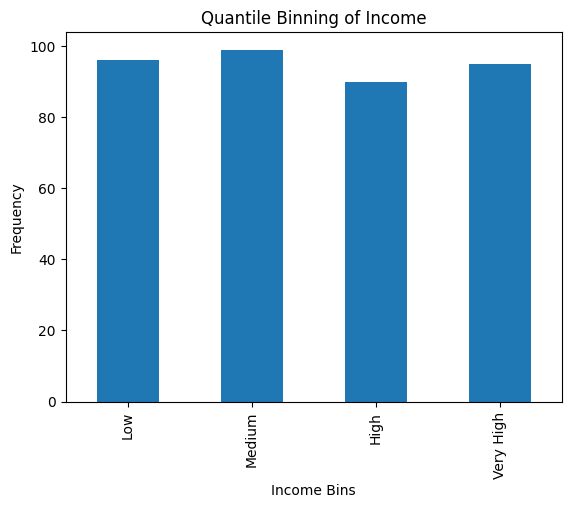

In [202]:
carseats_copy['Income_Quantile_Bins'] = pd.qcut(carseats['Income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Display the first few rows with the new column
print(carseats_copy[['Income', 'Income_Quantile_Bins']].head())

# Visualize the distribution of the quantile bins
carseats_copy['Income_Quantile_Bins'].value_counts(sort=False).plot(kind='bar', title='Quantile Binning of Income')
plt.xlabel('Income Bins')
plt.ylabel('Frequency')
plt.savefig('./Exercise_4_images/8.png')
plt.show()

**Exercise 4.** Recode the original distribution of incomes using fixed length of intervals and assign them labels.


120.0
   Income Income_Fixed_Bins
0    73.0              High
1    48.0            Medium
2    35.0            Medium
3   100.0         Very High
4    64.0              High


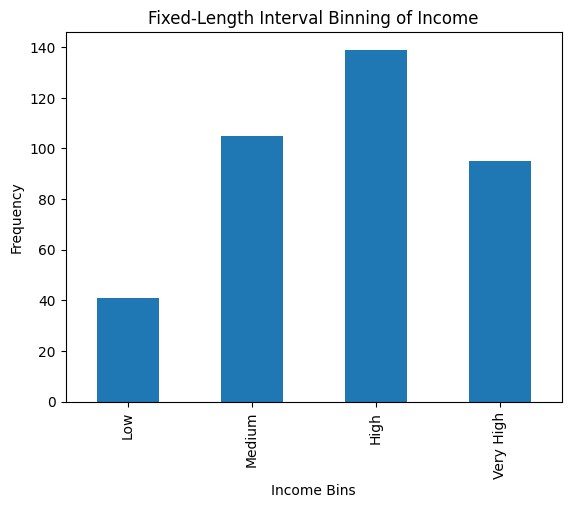

In [203]:
print(carseats['Income'].max())
bins = [0, 30, 60, 90, 120]
labels = ['Low', 'Medium', 'High', 'Very High']

# Perform fixed-length interval binning on the 'Income' column
carseats_copy['Income_Fixed_Bins'] = pd.cut(carseats['Income'], bins=bins, labels=labels, include_lowest=True)

# Display the first few rows with the new column
print(carseats_copy[['Income', 'Income_Fixed_Bins']].head())
# Visualize the distribution of the fixed-length bins
carseats_copy['Income_Fixed_Bins'].value_counts(sort=False).plot(kind='bar', title='Fixed-Length Interval Binning of Income')
plt.xlabel('Income Bins')
plt.ylabel('Frequency')
plt.savefig('./Exercise_4_images/9.png')
plt.show()

In case of statistical modeling (i.e. credit scoring purposes) - we need to be aware of the fact, that the ***optimal*** discretization of the original distribution must be achieved. The '*binning_by*' function comes with some help here.

## Optimal binning with binary target

**Exercise 5.** Perform discretization of the variable 'Advertising' using optimal binning.

In [204]:
from optbinning import OptimalBinning
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

We choose a variable to discretize and the binary target.

In [205]:
variable = "mean radius"
x = df[variable].values
y = data.target

Import and instantiate an OptimalBinning object class. We pass the variable name, its data type, and a solver, in this case, we choose the constraint programming solver.

In [206]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

We fit the optimal binning object with arrays x and y.

In [207]:
optb.fit(x, y)

OptimalBinning(name='mean radius')

You can check if an optimal solution has been found via the status attribute:

In [208]:
optb.status

'OPTIMAL'

You can also retrieve the optimal split points via the splits attribute:

In [209]:
optb.splits

array([11.42500019, 12.32999992, 13.09499979, 13.70499992, 15.04500008,
       16.92500019])

The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class OptimalBinning returns an object BinningTable via the binning_table attribute.

In [210]:
binning_table = optb.binning_table

type(binning_table)

optbinning.binning.binning_statistics.BinningTable

The binning_table is instantiated, but not built. Therefore, the first step is to call the method build, which returns a pandas.DataFrame.

In [211]:
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.43)",118,0.207381,3,115,0.974576,-3.12517,0.962483,0.087205
1,"[11.43, 12.33)",79,0.138840,3,76,0.962025,-2.710972,0.538763,0.052198
2,"[12.33, 13.09)",68,0.119508,7,61,0.897059,-1.643814,0.226599,0.025513
3,"[13.09, 13.70)",49,0.086116,10,39,0.795918,-0.839827,0.052131,0.006331
4,"[13.70, 15.05)",83,0.145870,28,55,0.662651,-0.153979,0.003385,0.000423
5,"[15.05, 16.93)",54,0.094903,44,10,0.185185,2.002754,0.359566,0.038678
6,"[16.93, inf)",118,0.207381,117,1,0.008475,5.283323,2.900997,0.183436
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,569,1.000000,212,357,0.627417,,5.043925,0.393784


Let’s describe the columns of this binning table:

Bin: the intervals delimited by the optimal split points.  
Count: the number of records for each bin.  
Count (%): the percentage of records for each bin.  
Non-event: the number of non-event records (𝑦=0) for each bin.  
Event: the number of event records (𝑦=1) for each bin.  
Event rate: the percentage of event records for each bin.  
WoE: the Weight-of-Evidence for each bin.  
IV: the Information Value (also known as Jeffrey’s divergence) for each bin.  
JS: the Jensen-Shannon divergence for each bin.  
The last row shows the total number of records, non-event records, event records, and IV and JS.    

You can use the method plot to visualize the histogram and WoE or event rate curve. Note that the Bin ID corresponds to the binning table index.

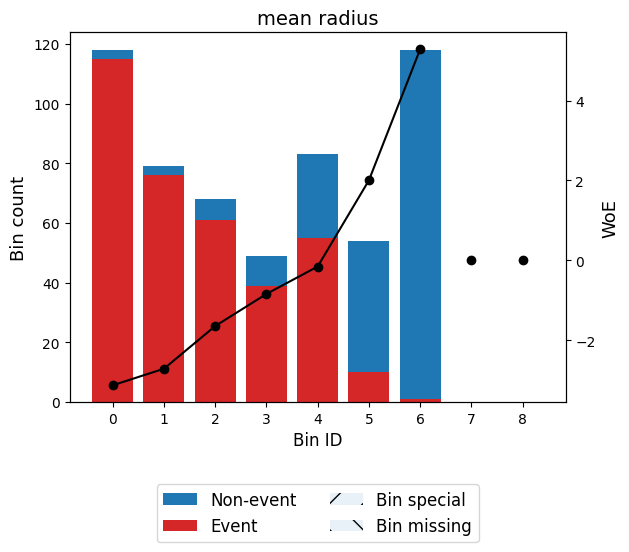

<Figure size 640x480 with 0 Axes>

In [212]:
binning_table.plot(metric="woe")
plt.savefig('./Exercise_4_images/10.png')

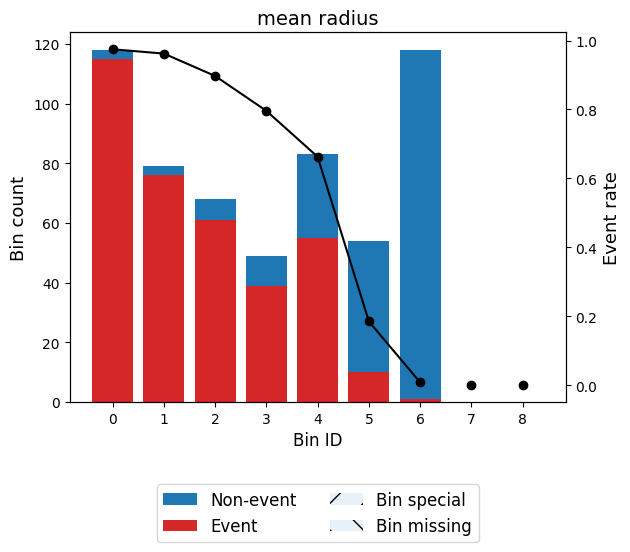

<Figure size 640x480 with 0 Axes>

In [213]:
binning_table.plot(metric="event_rate")
plt.savefig('./Exercise_4_images/11.png')

Note that WoE is inversely related to the event rate, i.e., a monotonically ascending event rate ensures a monotonically descending WoE and vice-versa. We will see more monotonic trend options in the advanced tutorial.

Read more here: [https://gnpalencia.org/optbinning/tutorials/tutorial_binary.html](https://gnpalencia.org/optbinning/tutorials/tutorial_binary.html)

## Working with 'missingno' library

<iframe width="560" height="315" src="https://www.youtube.com/embed/Wdvwer7h-8w?si=pVqCbOXb4CaCsmnJ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

**Exercise 6.** Your turn! 

Work with the 'carseats' dataset, find the best way to perform full diagnostic (dirty data, outliers, missing values). Fix problems.

Missing Values:
Sales           1
CompPrice       2
Income         20
Advertising     1
Population      0
Price           7
ShelveLoc       0
Age             0
Education       0
Urban          10
US              0
dtype: int64


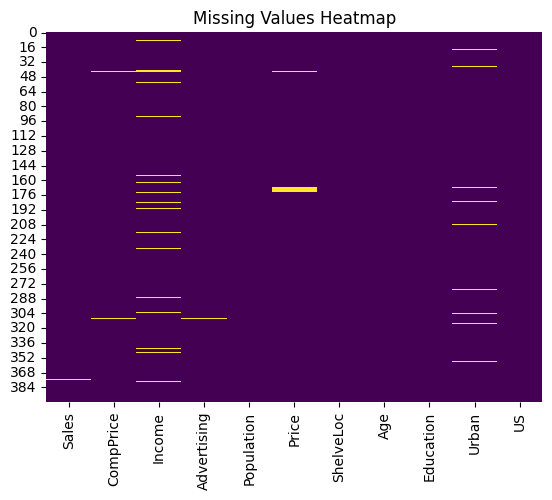

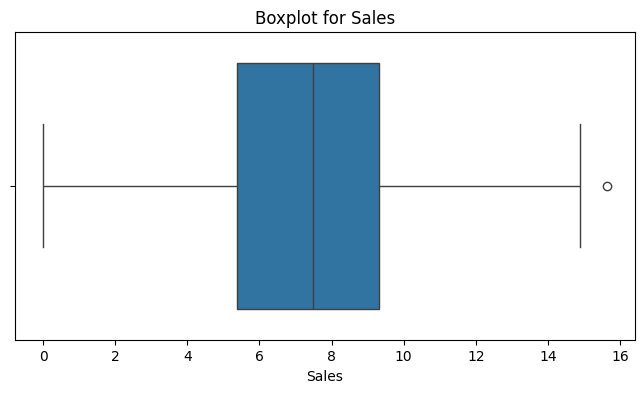

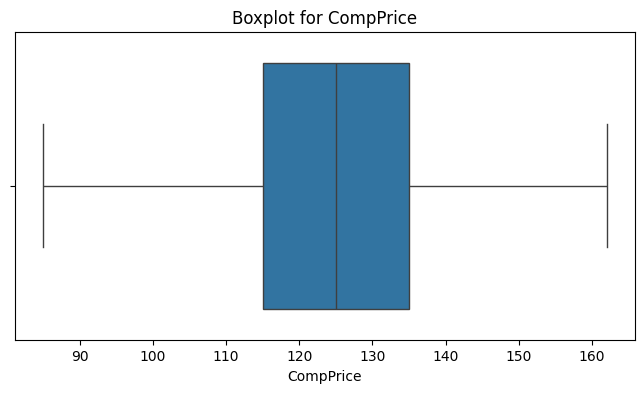

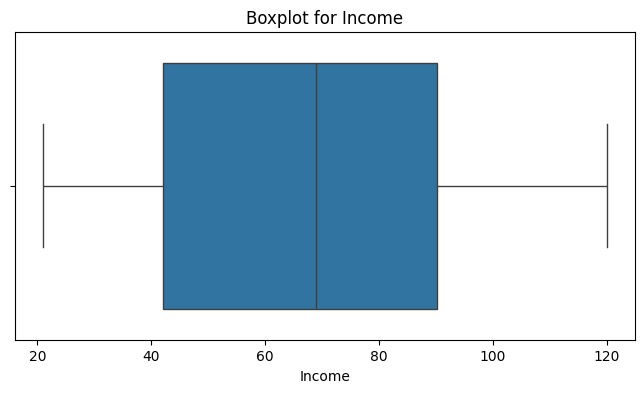

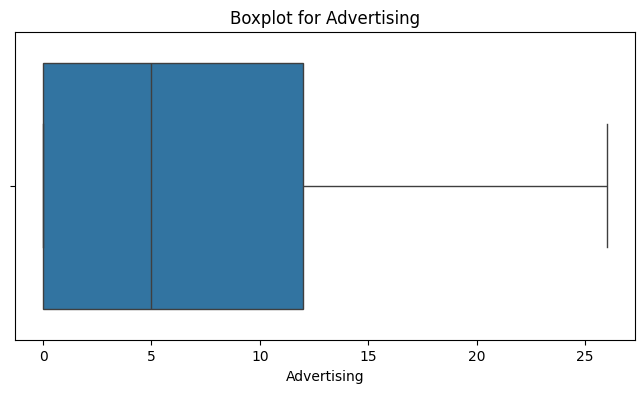

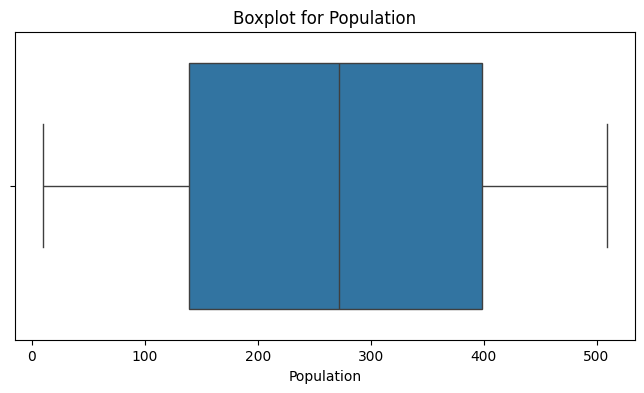

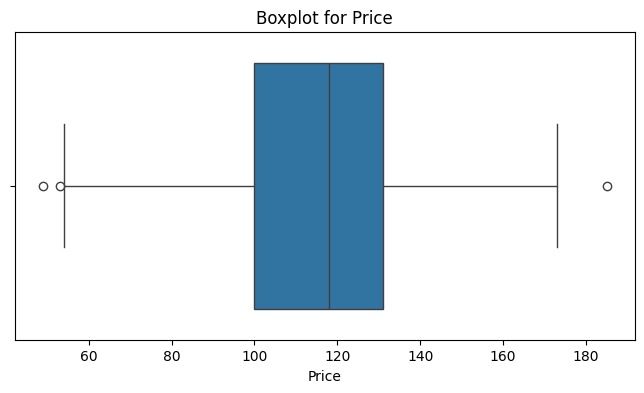

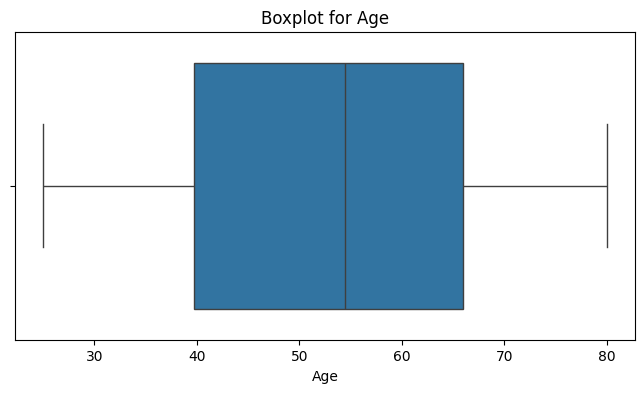

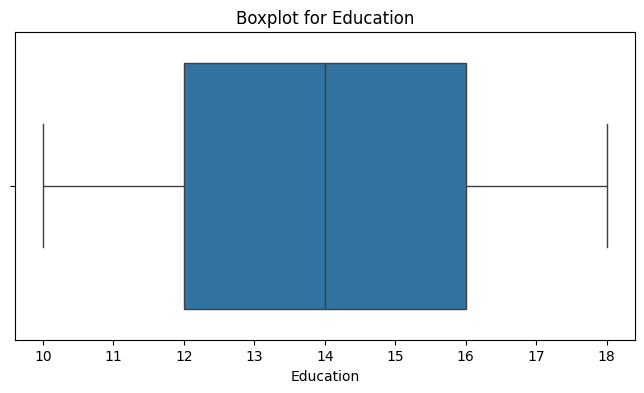

Outliers Detected:
Sales: 0 outlier(s)
CompPrice: 0 outlier(s)
Income: 0 outlier(s)
Advertising: 0 outlier(s)
Population: 0 outlier(s)
Price: 1 outlier(s)
Age: 0 outlier(s)
Education: 0 outlier(s)
Updated DataFrame with Outliers Replaced by NaN:
Sales           1
CompPrice       2
Income         20
Advertising     1
Population      0
Price           8
ShelveLoc       0
Age             0
Education       0
Urban          10
US              0
dtype: int64


In [220]:
from scipy.stats import zscore
print("Missing Values:")
print(carseats.isnull().sum())
# Visualize missing values
sns.heatmap(carseats.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.savefig(f'./Exercise_4_images/12.png')
plt.show()
numerical_columns = carseats.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=carseats[col])
    plt.title(f"Boxplot for {col}")
    plt.show()
outliers = {}
for col in numerical_columns:
    z_scores = zscore(carseats[col].dropna())
    outliers[col] = np.where(np.abs(z_scores) > 3)[0]    
print("Outliers Detected:")
for col, indices in outliers.items():
    print(f"{col}: {len(indices)} outlier(s)")     
# seeing some outliers i decide to convert them to np.nan
for col, indices in outliers.items():
    carseats.loc[carseats.index[indices], col] = np.nan

# Verify the changes
print("Updated DataFrame with Outliers Replaced by NaN:")
print(carseats.isnull().sum())
# we can see that the outliers became np.nan and we may impute them using the KNNImputer

In [ ]:

numerical_columns = carseats.select_dtypes(include=[np.number]).columns
categorical_columns = carseats.select_dtypes(exclude=[np.number]).columns
for col in categorical_columns:
    carseats[col].fillna(carseats[col].mode()[0], inplace=True)
    # i checked and without this ter urban columns didn't get imputed
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_categorical = pd.DataFrame(encoder.fit_transform(carseats[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

# Combine numeric and encoded categorical columns
encoded_carseats = pd.concat([carseats[numerical_columns], encoded_categorical], axis=1)

# Initialize the KNNImputer
imputer = KNNImputer()
imputed_carseats = imputer.fit_transform(encoded_carseats)

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_carseats, columns=encoded_carseats.columns)

# Decode the one-hot encoded columns back to original categorical columns
decoded_categorical = pd.DataFrame(encoder.inverse_transform(imputed_df[encoded_categorical.columns]), columns=categorical_columns)

# Combine numeric and decoded categorical columns
final_imputed_data = pd.concat([imputed_df[numerical_columns], decoded_categorical], axis=1)

# Print the imputed data
print(final_imputed_data)

     Sales  CompPrice  Income  Advertising  Population  Price   Age  \
0     9.50      138.0    73.0         11.0       276.0  120.0  42.0   
1    11.22      111.0    48.0         16.0       260.0   83.0  65.0   
2    10.06      113.0    35.0         10.0       269.0   80.0  59.0   
3     7.40      117.0   100.0          4.0       466.0   97.0  55.0   
4     4.15      141.0    64.0          3.0       340.0  128.0  38.0   
..     ...        ...     ...          ...         ...    ...   ...   
395  12.57      138.0   108.0         17.0       203.0  128.0  33.0   
396   6.14      139.0    23.0          3.0        37.0  120.0  55.0   
397   7.41      162.0    26.0         12.0       368.0  159.0  40.0   
398   5.94      100.0    79.0          7.0       284.0   95.0  50.0   
399   9.71      134.0    37.0          0.0        27.0  120.0  49.0   

     Education ShelveLoc Urban   US  
0         17.0       Bad   Yes  Yes  
1         10.0      Good   Yes  Yes  
2         12.0    Medium   Yes  Y